## Import the Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    # Spiliting on basic of space
    sents = text.strip().split('\n')
    # Spliting on basic of tab Space
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
# Calling the read and then split function on the dataset
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
# Let’s first take a look at our data, Here I am using all the data for training
# This dataset has around 150,000 sentence-pairs
deu_eng = deu_eng[:150000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["It's a good thing that you showed up.",
        'Es ist gut, dass du vorbeigekommen bist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #8216127 (CK) & #8220797 (MisterTrouser)'],
       ["It's a lot of fun to listen to music.",
        'Musik zu hören macht sehr viel Spaß.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #7810549 (CM) & #330601 (Sprachprofi)'],
       ["It's a matter of personal preference.",
        'Das ist eine Frage des persönlichen Geschmacks.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4590023 (Hybrid) & #6932886 (Pfirsichbaeumchen)']],
      dtype='<U537')

In the dataset, we have to remove all the punctuation and convert to data to lower case.

## Data Pre-Processing

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Its a good thing that you showed up',
        'Es ist gut dass du vorbeigekommen bist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #8216127 (CK) & #8220797 (MisterTrouser)'],
       ['Its a lot of fun to listen to music',
        'Musik zu hören macht sehr viel Spaß',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #7810549 (CM) & #330601 (Sprachprofi)'],
       ['Its a matter of personal preference',
        'Das ist eine Frage des persönlichen Geschmacks',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4590023 (Hybrid) & #6932886 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [7]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['its a good thing that you showed up',
        'es ist gut dass du vorbeigekommen bist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #8216127 (CK) & #8220797 (MisterTrouser)'],
       ['its a lot of fun to listen to music',
        'musik zu hören macht sehr viel spaß',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #7810549 (CM) & #330601 (Sprachprofi)'],
       ['its a matter of personal preference',
        'das ist eine frage des persönlichen geschmacks',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4590023 (Hybrid) & #6932886 (Pfirsichbaeumchen)']],
      dtype='<U537')

### We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

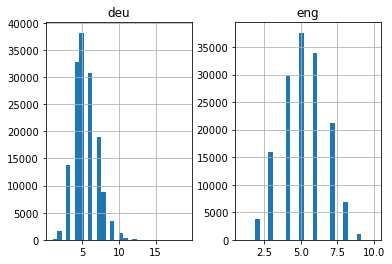

In [8]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

### Tokenizers for both the German and English sentences

In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 12061


In [11]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 23549


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [13]:
# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

## Encoding the Sentences

In [14]:
# A Seq2Seq model requires that we convert both the input and the output sentences 
# into integer sequences of fixed length

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

## Sequence-to-Sequence (Seq2Seq) Model Training

We’ll start off by defining our Seq2Seq model architecture

In [15]:
# Build Netural Machine Translation model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
# For the encoder, we will use an embedding layer and an LSTM layer
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
# For the decoder, we will use another LSTM layer followed by a dense layer    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [16]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model.summary()
# Here, I am using RMSprop optimizer and sparse_categorical_crossentropy as a loss function
rms = optimizers.RMSprop(lr=0.001)

# Compiling the model
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            12057088  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 12061)          6187293   
Total params: 22,442,781
Trainable params: 22,442,781
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Initilizing the model file name
filename = 'model.h1'

# Adding checkpoint to save model incase error occureed during training 
# Verbose = 2 display detaiiled infomation about each epochs 
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

d:\pycharmprojects\sem2\venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 96000 samples, validate on 24000 samples
Epoch 1/30
96000/96000 [==============================] - 24s 247us/step - loss: 4.2385 - val_loss: 3.8752

Epoch 00001: val_loss improved from inf to 3.87518, saving model to model.h1
Epoch 2/30
96000/96000 [==============================] - 23s 239us/step - loss: 3.6894 - val_loss: 3.5649

Epoch 00002: val_loss improved from 3.87518 to 3.56486, saving model to model.h1
Epoch 3/30
96000/96000 [==============================] - 23s 240us/step - loss: 3.3626 - val_loss: 3.2490

Epoch 00003: val_loss improved from 3.56486 to 3.24895, saving model to model.h1
Epoch 4/30
96000/96000 [==============================] - 23s 241us/step - loss: 3.0501 - val_loss: 2.9616

Epoch 00004: val_loss improved from 3.24895 to 2.96157, saving model to model.h1
Epoch 5/30
96000/96000 [==============================] - 23s 240us/step - loss: 2.7591 - val_loss: 2.7714

Epoch 00005: val_loss improved from 2.96157 to 2.77141, saving model to model.h1
Epoch 6/3

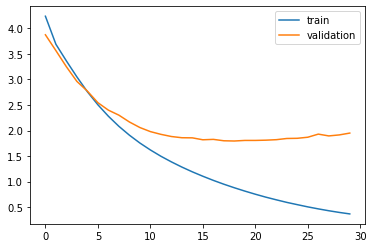

In [18]:
# Training and Validation graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

## Prediction

In [19]:
# Loading the Model file
model = load_model('model.h1')
# Predcting the output
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

d:\pycharmprojects\sem2\venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Evaluating Model

In [20]:
# These predictions are sequences of integers. We need to convert these integers to their corresponding words
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [21]:
# Convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                 temp.append('')
            else:
                 temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [22]:
# Creating a Dataframe
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [23]:
# print first 15 rows 
pred_df[:15]

,actual,predicted
0,they were both dirty,they were both
1,how many sisters do you have,how many sisters do you have
2,dont be alarmed,dont be like
3,ill manage,ill be
4,stop being so emotional,stop being so immature
5,tom makes his own bread,tom makes his own bread
6,tom could end up being arrested,tom could be the
7,tom has decided to go,tom has decided to go
8,tom says no teachers were there,tom said he didnt had a teacher
9,where on earth were you,what the world been you


### Conculsion

Our model of the Seq2Seq does a good job. Yet there are also cases in which it fails to grasp the main terms. For example, it translates “dont be alarmed” to “dont be about”.

### Recomendation

We can easily boost this performance using a more sophisticated encoder-decoder model on a wider dataset.